# Inicialização

In [1]:
import psycopg2
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import scipy

from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
dict_connect = {
    "dbname" : "lista4",
    "user" : "postgres",
    "password": "123321",
    "host": "localhost"
}
conn = psycopg2.connect(**dict_connect)
df = pd.read_sql('SELECT * FROM tb_whatsapp_messages', con=conn)
df.info()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_17520\255694495.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT * FROM tb_whatsapp_messages', con=conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407957 entries, 0 to 407956
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      407957 non-null  int64         
 1   date_message            407957 non-null  datetime64[ns]
 2   id_member_anonymous     407957 non-null  object        
 3   ddi                     407957 non-null  object        
 4   ddd                     406311 non-null  object        
 5   country                 407866 non-null  object        
 6   country_iso3            407866 non-null  object        
 7   state                   406311 non-null  object        
 8   id_group_anonymous      407957 non-null  object        
 9   media                   185568 non-null  object        
 10  media_type              187528 non-null  object        
 11  media_url               132949 non-null  object        
 12  has_media               407957

# Tratamento dos dados

## Filtrando as colunas úteis relacionadas ao texto

In [3]:
df = df[["text_content_anonymous", "media_url", "trava_zap", "has_media", "has_media_url", "score_sentiment", "score_misinformation"]]
df.head()

,text_content_anonymous,media_url,trava_zap,has_media,has_media_url,score_sentiment,score_misinformation
0,None,None,False,True,False,NaN,NaN
1,Vou ali,None,False,False,False,0.0000,NaN
2,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867
3,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867
4,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867


## Removendo NaNs

In [4]:
print(df.shape[0])
df = df[ (~df.text_content_anonymous.isna()) & (df.text_content_anonymous != "None") ]
print(df.shape[0])

df

407957
269473


,text_content_anonymous,media_url,trava_zap,has_media,has_media_url,score_sentiment,score_misinformation
1,Vou ali,None,False,False,False,0.0000,NaN
2,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867
3,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867
4,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867
5,*Dilma merece pedido de desculpas por impeachm...,None,False,False,False,0.4019,NaN
...,...,...,...,...,...,...,...
407949,*Colisão no cruzamento do perímetro urbano da ...,https://surgiu.com.br/2023/11/18/colisao-no-cr...,False,False,True,0.6369,0.001697
407952,Vamos divulgar. Eles estão pedindo a nossa par...,None,False,True,False,0.8834,0.507464
407953,*Vejam a desgraça que o governo Lula está faze...,None,False,True,False,-0.7351,0.962875
407954,*CONFIRA O CALENDARIO DO BOLSA FAMILIA PARA ES...,None,False,False,False,-0.3254,NaN


## Colunas score_sentiment e score_misinformation

In [5]:
df.loc[:, "score_misinformation"] = df["score_misinformation"].fillna(df["score_misinformation"].quantile(0.5))

In [6]:
df.describe()

,score_sentiment,score_misinformation
count,269473.000000,269473.000000
mean,-0.055079,0.212823
std,0.401148,0.147730
min,-0.999800,0.000002
25%,-0.282400,0.187924
50%,0.000000,0.187924
75%,0.000000,0.187924
max,0.999700,1.000000


## Adicionando o Target e removendo duplicatas

In [7]:
texto_target = df.groupby("text_content_anonymous")["text_content_anonymous"].count()
df = df.merge(texto_target, left_on = "text_content_anonymous", right_index = True)
df = df.rename(columns = {"text_content_anonymous_y": "viralizacao"})
df = df.drop(columns = "text_content_anonymous_x")

In [8]:
limiar = df.viralizacao.quantile(0.9)
limiar

14.0

In [9]:
df["viralizacao"] = df["viralizacao"].apply(lambda x: 1 if x > limiar else 0)
df.viralizacao.value_counts()

viralizacao
0    243433
1     26040
Name: count, dtype: int64

In [10]:
print(df.shape[0])
#df = df[ ~(df.text_content_anonymous.duplicated()) ] 
print(df.shape[0])

df

269473
269473


,text_content_anonymous,media_url,trava_zap,has_media,has_media_url,score_sentiment,score_misinformation,viralizacao
1,Vou ali,None,False,False,False,0.0000,0.187924,0
2,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867,0
3,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867,0
4,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867,0
67,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867,0
...,...,...,...,...,...,...,...,...
407948,*Acho que você vai adorar este vídeo!*\nhttps:...,https://kwai-video.com/p/ChwHf3Pq,False,False,True,0.7177,0.187924,0
407949,*Colisão no cruzamento do perímetro urbano da ...,https://surgiu.com.br/2023/11/18/colisao-no-cr...,False,False,True,0.6369,0.001697,0
407952,Vamos divulgar. Eles estão pedindo a nossa par...,None,False,True,False,0.8834,0.507464,0
407953,*Vejam a desgraça que o governo Lula está faze...,None,False,True,False,-0.7351,0.962875,0


# Divisão de treino e teste

In [11]:
df.viralizacao.value_counts()

viralizacao
0    243433
1     26040
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

# Diminuindo os dados momentaneamente para testar a pipeline
LIMITAR = int(df.shape[0] * 0.1)
print(LIMITAR)
amostra = df.copy().sample(LIMITAR, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(amostra.drop(columns = 'viralizacao'), amostra.viralizacao, test_size=0.4, random_state=42)

y_test.value_counts()

26947


viralizacao
0    9738
1    1041
Name: count, dtype: int64

# Criação da pipeline
Tentar fazer tudo usando um grid_search na qual cada parâmetro seria da pipeline

- Regularização: model_parametros
- Normalização: normalization_parametros
- Pré-processamento: preprocessing_parametros
- Embeddings: embeddings_parametros
- N-Gramas: embeddings_parametros
- Usar 3 fold cross validation

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin


## Pré-processamento

In [14]:
from urllib.parse import urlparse
import re
import string
import nltk
import emoji
import unidecode
import spacy
from spacy.tokenizer import Tokenizer






def limit_repetitions(text, max_repetitions=3):
    pattern = r"(.)\1{" + str(max_repetitions) + r",}"
    return re.sub(pattern, lambda m: m.group(1) * max_repetitions, text)

def get_root_domain(url):
    parsed_url = urlparse(url)
    root_domain = f"{parsed_url.hostname}"
    return root_domain


def preprocessamento(X):
    texto_usuario = X['text_content_anonymous']
    url = X['media_url']

    # extraindo dominio da url
    url_nova = url.apply(get_root_domain).copy()


    # substituindo os dominios no texto
    for i in texto_usuario.index:
        if url.at[i]:  # Verifica se a URL não é vazia
            texto_usuario.at[i] = texto_usuario.at[i].replace(url.at[i], url_nova.at[i])


    # letras para minusculo
    texto_usuario = texto_usuario.apply(lambda x: x.lower())

    # limitando repetições de caracteres
    texto_usuario = texto_usuario.apply(limit_repetitions)
    
    # emojis
    texto_usuario = texto_usuario.apply(emojis_to_aliases)

    # separando emojis
    texto_usuario = texto_usuario.apply(lambda x: x.replace("::", ": :"))

    # pequeno tratamento
    def insert_space_before_colon(text):
        pattern = r'(?<=[.,!?]):'
        return re.sub(pattern, ' :', text)
    texto_usuario = texto_usuario.apply(insert_space_before_colon)

    # removendo caracteres indesejaveis
    caracteres_permitidos = "abcdefghijklmnopqrstuvwxyzàáâãèéêìíîòóôõùúûç:*_"
    texto_usuario = texto_usuario.apply(lambda x: x.replace("/n", " "))
    verificar_caracteres = lambda texto: any(char in "abcdefghijklmnopqrstuvwxyzàáâãèéêìíîòóôõùúûç" for char in texto)
    texto_usuario = texto_usuario.apply( lambda x: " ".join( (token if verificar_caracteres(token) else "") for token in re.split(r'\s+', x) ) )
    texto_usuario = texto_usuario.apply(lambda x: " ".join( (word[:-1] if word[-1] in ".,!?" else word) for word in x.split()) )
    texto_usuario = texto_usuario.apply(lambda x: " ".join( (word[:-1] if word[-1] in ".,!?" else word) for word in x.split()) )
    texto_usuario = texto_usuario.apply(lambda x: " ".join( (word[:-1] if word[-1] in ".,!?" else word) for word in x.split()) )

    # removendo stop words
    stop_words = nltk.corpus.stopwords.words("portuguese")
    stop_words.remove("não")
    texto_usuario = texto_usuario.apply(lambda x: " ".join( filter(lambda word: word not in stop_words, x.split()) ))

    # lematizacao
    nlp = spacy.load('pt_core_news_sm')
    def custom_tokenizer(nlp):
        return Tokenizer(nlp.vocab, token_match=None)
    nlp.tokenizer = custom_tokenizer(nlp)
    texto_usuario = texto_usuario.apply(lambda x: " ".join(token.lemma_ for token in nlp(x) ))

    # removendo acentuacoes
    texto_usuario = texto_usuario.apply(unidecode.unidecode)
    

    return texto_usuario

def emojis_to_aliases(text):
    return emoji.demojize(text)

exemplos = X_train.sample(5)
textos1 = exemplos.text_content_anonymous
textos2 = preprocessamento(exemplos)
for i in range(len(textos1)):
    print(textos1.iloc[i])
    print("----- VVV -----")
    print(textos2.iloc[i])
    print()

www.instagram.com?igshid=MTduZXhmc2EzNTEzbg==
----- VVV -----
www.instagram.com?igshid=mtduzxhmc2ezntezbg==

Entendeu ou quer que desenhe?🤷🏻‍♂️ O tráfico ganhou até cadeira no governo. 🤦🏻‍♂️ Só cego (e quem não quer) não vê! 😒
----- VVV -----
entender querer desenhe :man_shrugging_light_skin_tone: trafico ganhar cadeira governo :man_facepalming_light_skin_tone: cego (e nao quer) nao ver :unamused_face:

*IMPOSTO DE RENDA* - Decreto que aumenta de 27,5 para 35% , a aliquota do Imposto de Renda. - Este reajuste atinge diretamente a classe média. - Sem querer cortar gastos, o governo com sua exuberante incompetência, quer como sempre, repassar para a populacão. - Assim é moleza, roubam, administram mal, e nos dão a conta para pagar. Passe adiante... - Se cada pessoa passar para 10 amigos de setores diferentes, no 6° repasse atingiremos milhões de brasileiros . - Vamos tirar 5 minutos para mudar o Brasil e defender nossas famílias e nosso suado dinheiro. Eu fiz minha parte ! Faça a sua!   

In [15]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, aplicar_processamento=False):
        self.aplicar_processamento = aplicar_processamento

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.aplicar_processamento:
            X['text_content_anonymous'] = preprocessamento(X)
        return X

preprocessing_step = CustomPreprocessor()

## Embedding

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec


def text_to_vector(text, model):
    words = text.split()
    words = [word for word in words if word in model.wv]
    
    if len(words) == 0:
        return np.zeros(model.vector_size)

    word_vectors = np.array([model.wv[word] for word in words])
    return np.mean(word_vectors, axis=0)


class Embedding(BaseEstimator, TransformerMixin):
    def __init__(self, tipo_embedding = "BOW", n_grams = 1):
        self.tipo_embedding = tipo_embedding
        self.n_grams = n_grams
        self.QNT_FEATURES = 500

    def fit(self, X, y=None):

        if self.tipo_embedding == "BOW":
            self.vetorizador = CountVectorizer(max_features = self.QNT_FEATURES, ngram_range = (1,self.n_grams))
            self.vetorizador.fit(X.iloc[:,0])

        elif self.tipo_embedding == "TF-IDF":
            self.vetorizador = TfidfVectorizer(max_features = self.QNT_FEATURES, ngram_range = (1,self.n_grams))
            self.vetorizador.fit(X.iloc[:,0])

        elif self.tipo_embedding == "WORD2VEC":
            w2v_modelo = Word2Vec(
                sg = 0, # cbow
                window = self.n_grams * 2,
                vector_size  = self.QNT_FEATURES,
                min_count = 3,
                alpha = 0.03,
                min_alpha = 0.007
            )

            textos = X.iloc[:,0]
            lista_lista_tokens = [texto.split() for texto in textos]
            w2v_modelo.build_vocab(lista_lista_tokens, progress_per = 5000)

            w2v_modelo.train(lista_lista_tokens,
                 total_examples = w2v_modelo.corpus_count,
                 epochs = 400,
            )

            self.w2v_modelo = w2v_modelo

        else:
            raise Exception("Este embedding não está implementado ou não existe")
        
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if self.tipo_embedding == "BOW":
            bag_of_words = self.vetorizador.transform(X.iloc[:,0])
            bow = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=self.vetorizador.get_feature_names_out())
            bow.index = X.index
            X = pd.concat([X, bow], axis = 1)
    
        elif self.tipo_embedding == "TF-IDF":
            tf_idf = self.vetorizador.transform(X.iloc[:,0])
            tfidf = pd.DataFrame.sparse.from_spmatrix(tf_idf, columns=self.vetorizador.get_feature_names_out())
            tfidf.index = X.index
            X = pd.concat([X, tfidf], axis = 1)
    
        elif self.tipo_embedding == "WORD2VEC":
            textos = X.iloc[:,0]
            matriz = np.array([text_to_vector(texto, self.w2v_modelo) for texto in textos])
            word2vec = pd.DataFrame(data = matriz, index = X.index, columns = ["w2v_" + str(i) for i in range(1,self.QNT_FEATURES+1)])
            X = pd.concat([X, word2vec], axis = 1)
            
        
        else:
            raise Exception("Este embedding não está implementado ou não existe")

        X = X.drop(X.columns[[0,1]], axis=1)
        return X

embedding_step = Embedding()

## Normalização

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self, tipo_normalizacao = "nenhuma"):
        self.tipo_normalizacao = tipo_normalizacao

    def fit(self, X, y=None):
        if self.tipo_normalizacao == 'nenhuma':
            return self
        elif self.tipo_normalizacao == 'standard':
            scaler = StandardScaler()
        elif self.tipo_normalizacao == 'minmax':
            scaler = MinMaxScaler()
        else:
            raise ValueError(f"Tipo de normalização desconhecido: {self.tipo_normalizacao}")

        scaler.fit(X)
        self.scaler = scaler
        
        return self

    def transform(self, X):
        if self.tipo_normalizacao == 'nenhuma':
            return X
        elif self.tipo_normalizacao == 'standard' or self.tipo_normalizacao == 'minmax':
            return pd.DataFrame( self.scaler.transform(X), index = X.index, columns = X.columns )
        else:
            raise ValueError(f"Tipo de normalização desconhecido: {self.tipo_normalizacao}")


normalization_step = Normalizer()

## Modelo/Regularização

In [18]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


class CustomClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_type="LogisticRegression_None", random_state=None, threshold = 0.5):
        self.model_type = model_type
        self.random_state = random_state
        self.threshold = threshold

    def fit(self, X, y):
        if self.model_type == "LogisticRegression_None":
            self.model = LogisticRegression(random_state=self.random_state)
        elif self.model_type == "LogisticRegression_L1":
            self.model = LogisticRegression(penalty = "l1", solver = "liblinear", random_state=self.random_state)
        elif self.model_type == "LogisticRegression_L2":
            self.model = LogisticRegression(penalty = "l2", random_state=self.random_state)
        elif self.model_type == "LogisticRegression_ElasticNet":
            self.model = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.5, random_state=self.random_state)
        elif self.model_type == "DecisionTree":
            self.model = DecisionTreeClassifier(random_state=self.random_state)
        elif self.model_type == "RandomForest":
            self.model = RandomForestClassifier(random_state=self.random_state)
        else:
            raise ValueError(f"Tipo de modelo desconhecido: {self.model_type}")
        
        self.model = self.model.fit(X, y)
        return self

    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas[:, 1] >= self.threshold).astype(int)

    def predict_proba(self, X):
        if hasattr(self.model, "predict_proba"):
            return self.model.predict_proba(X)
        else:
            raise NotImplementedError(f"{self.model_type} não suporta predict_proba")

    def score(self, X, y):
        y_pred = self.predict(X)
        return f1_score(y, y_pred)

    def get_params(self, deep=True):
        return {"model_type": self.model_type, "random_state": self.random_state}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

model_step = CustomClassifier()


## Pipeline

In [19]:
# Função para ignorar um step se for None
def skip_if_none(step):
    return step if step is not None else FunctionTransformer()


pipeline = imblearn.pipeline.Pipeline([
    ('scaler', RandomUnderSampler(random_state = 42)),
    ('preprocessing', skip_if_none(preprocessing_step)),
    ('embedding', skip_if_none(embedding_step)),
    ('normalization', skip_if_none(normalization_step)),
    ('model', skip_if_none(model_step))
])

# Grid Search

In [20]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    "preprocessing__aplicar_processamento": [True, False],
    "embedding__tipo_embedding": ["BOW", "TF-IDF", "WORD2VEC"],
    "embedding__n_grams": [1,2,3],
    "normalization__tipo_normalizacao": ["nenhuma", "minmax", "standard"],
    "model__model_type": ["LogisticRegression_None", "LogisticRegression_L1", "LogisticRegression_L2", "LogisticRegression_ElasticNet", "DecisionTree", "RandomForest"]
    
}


#param_search = RandomizedSearchCV(pipeline, param_grid, n_iter = 6, cv=3, n_jobs=6, verbose=1)
#param_search.fit(X_train, y_train)

param_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=6, verbose=1)
param_search.fit(X_train, y_train)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler',
                                        RandomUnderSampler(random_state=42)),
                                       ('preprocessing', CustomPreprocessor()),
                                       ('embedding', Embedding()),
                                       ('normalization', Normalizer()),
                                       ('model', CustomClassifier())]),
             n_jobs=6,
             param_grid={'embedding__n_grams': [1, 2, 3],
                         'embedding__tipo_embedding': ['BOW', 'TF-IDF',
                                                       'WORD2VEC'],
                         'model__model_type': ['LogisticRegression_None',
                                               'LogisticRegression_L1',
                                               'LogisticRegression_L2',
                                               'LogisticRegression_ElasticNet',
                                               'DecisionTree', 'RandomForest'],
                         'normalization__tipo_normalizacao': ['nenhuma',
                                                              'minmax',
                                                              'standard'],
                         'preprocessing__aplicar_processamento': [True, False]},
             verbose=1)

In [21]:
print("Melhores parâmetros encontrados:")
print(param_search.best_params_)
print("Melhor pontuação:")
print(param_search.best_score_)

Melhores parâmetros encontrados:
{'embedding__n_grams': 3, 'embedding__tipo_embedding': 'WORD2VEC', 'model__model_type': 'RandomForest', 'normalization__tipo_normalizacao': 'standard', 'preprocessing__aplicar_processamento': False}
Melhor pontuação:
0.6782997370664682


In [22]:
from joblib import dump

print("\nResultados de todos os parâmetros:")
melhor_modelo = param_search.best_estimator_
dump(melhor_modelo, 'melhor_modelo.pkl')

matriz_resultados = []
for params, mean_score, scores in zip(param_search.cv_results_['params'], 
                                      param_search.cv_results_['mean_test_score'],
                                      param_search.cv_results_['std_test_score']):

    matriz_resultados.append( [*params.values(), mean_score, scores] )
df_resultados = pd.DataFrame(matriz_resultados, columns = [*param_search.cv_results_['params'][0].keys(), "mean_test_score", "std_test_score" ])
df_resultados.to_csv("resultados_modelos.csv")
df_resultados.nlargest(10, columns = "mean_test_score")


Resultados de todos os parâmetros:


,embedding__n_grams,embedding__tipo_embedding,model__model_type,normalization__tipo_normalizacao,preprocessing__aplicar_processamento,mean_test_score,std_test_score
323,3,WORD2VEC,RandomForest,standard,False,0.678300,0.017645
319,3,WORD2VEC,RandomForest,nenhuma,False,0.677502,0.012822
321,3,WORD2VEC,RandomForest,minmax,False,0.673451,0.012122
215,2,WORD2VEC,RandomForest,standard,False,0.665417,0.006148
211,2,WORD2VEC,RandomForest,nenhuma,False,0.664765,0.008630
213,2,WORD2VEC,RandomForest,minmax,False,0.663023,0.011372
107,1,WORD2VEC,RandomForest,standard,False,0.662304,0.015842
105,1,WORD2VEC,RandomForest,minmax,False,0.660714,0.011477
103,1,WORD2VEC,RandomForest,nenhuma,False,0.656490,0.016023
322,3,WORD2VEC,RandomForest,standard,True,0.631604,0.025951


# Análise dos resultados

In [31]:
df_resultados = pd.read_csv("resultados_modelos.csv")

<Axes: xlabel='mean_test_score', ylabel='model__model_type'>

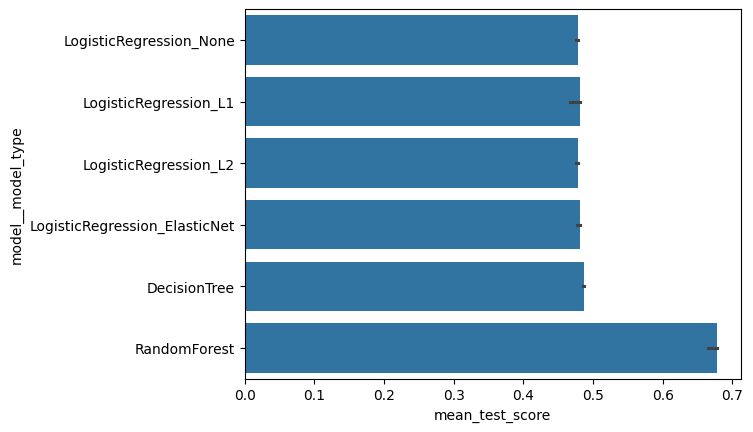

In [36]:
sns.barplot(df_resultados, y = "model__model_type", x = "mean_test_score", estimator = "max")

<Axes: xlabel='mean_test_score', ylabel='embedding__tipo_embedding'>

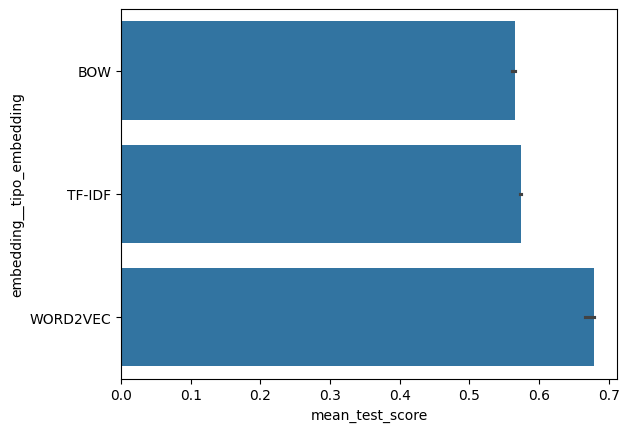

In [37]:
sns.barplot(df_resultados, y = "embedding__tipo_embedding", x = "mean_test_score", estimator = "max")

<Axes: xlabel='mean_test_score', ylabel='embedding__n_grams'>

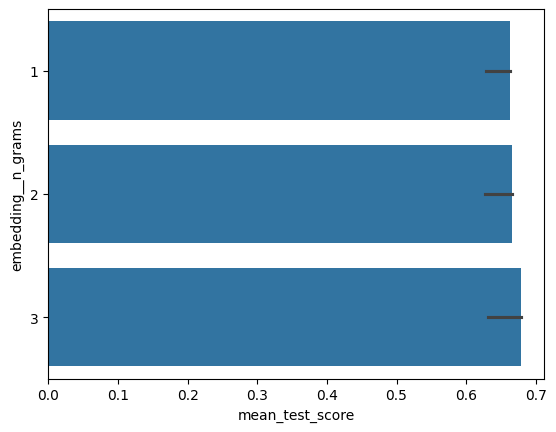

In [38]:
sns.barplot(df_resultados, y = "embedding__n_grams", x = "mean_test_score", orient = "h", estimator = "max")

<Axes: xlabel='mean_test_score', ylabel='normalization__tipo_normalizacao'>

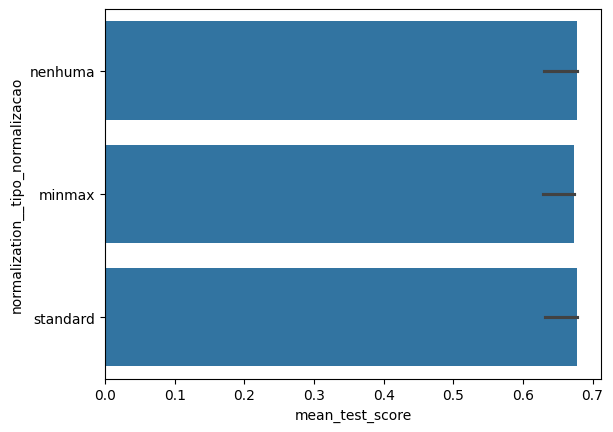

In [39]:
sns.barplot(df_resultados, y = "normalization__tipo_normalizacao", x = "mean_test_score", orient = "h", estimator = "max")

<Axes: xlabel='mean_test_score', ylabel='preprocessing__aplicar_processamento'>

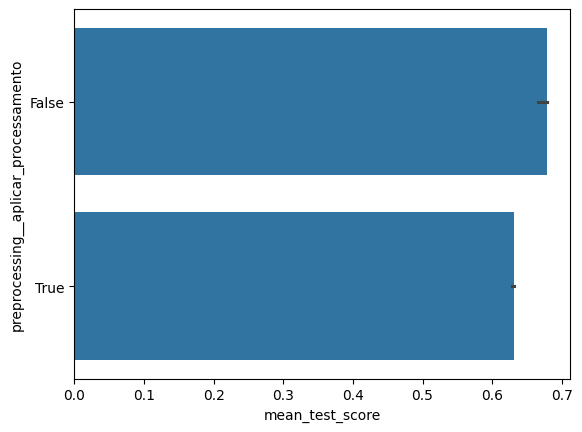

In [40]:
sns.barplot(df_resultados, y = "preprocessing__aplicar_processamento", x = "mean_test_score", orient = "h", estimator = "max")

<Axes: xlabel='embedding__tipo_embedding', ylabel='model__model_type'>

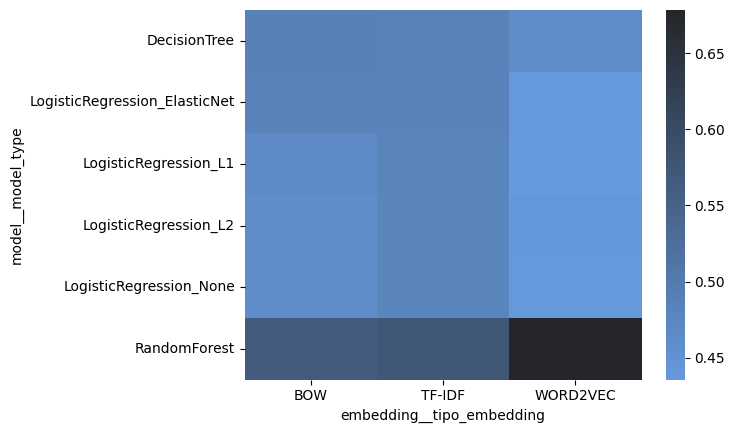

In [26]:
aux = pd.pivot_table(df_resultados, index = "model__model_type", columns = "embedding__tipo_embedding", values = "mean_test_score", aggfunc = "max")
sns.heatmap(aux, cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True))

# Análise do melhor modelo

In [41]:
from joblib import load
from sklearn.metrics import classification_report

melhor_modelo = load('melhor_modelo.pkl')


In [42]:
y_pred = melhor_modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     97381
           1       0.65      0.89      0.75     10409

    accuracy                           0.94    107790
   macro avg       0.82      0.92      0.86    107790
weighted avg       0.96      0.94      0.95    107790



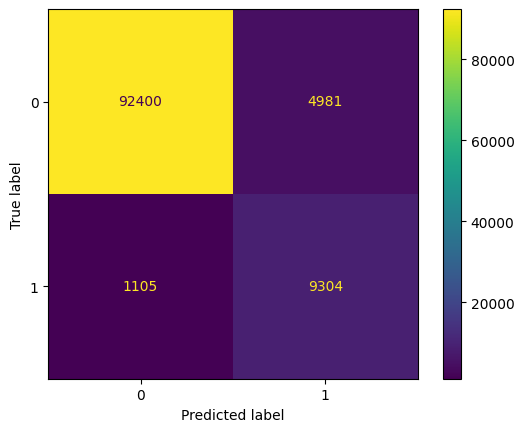

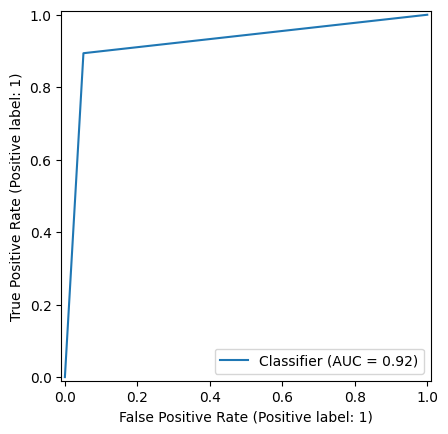

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
RocCurveDisplay.from_predictions(y_test, y_pred)

# Testando para o dataset inteiro

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'viralizacao'), df.viralizacao, test_size=0.4, random_state=42)


In [27]:
best_pipeline = imblearn.pipeline.Pipeline([
    ('scaler', RandomUnderSampler(random_state = 42)),
    ('preprocessing', CustomPreprocessor(aplicar_processamento = False)),
    ('embedding', Embedding(n_grams = 3, tipo_embedding = 'WORD2VEC')),
    ('normalization', Normalizer(tipo_normalizacao = 'standard')),
    ('model', CustomClassifier(model_type = 'RandomForest'))
])


In [28]:
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', RandomUnderSampler(random_state=42)),
                ('preprocessing', CustomPreprocessor()),
                ('embedding', Embedding(n_grams=3, tipo_embedding='WORD2VEC')),
                ('normalization', Normalizer(tipo_normalizacao='standard')),
                ('model', CustomClassifier(model_type='RandomForest'))])

In [29]:
y_pred = best_pipeline.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     97381
           1       0.91      1.00      0.95     10409

    accuracy                           0.99    107790
   macro avg       0.96      0.99      0.97    107790
weighted avg       0.99      0.99      0.99    107790



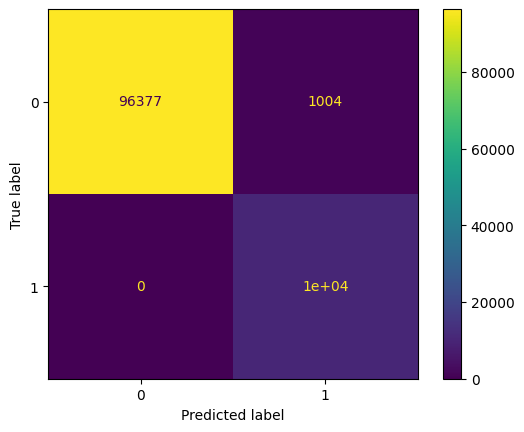

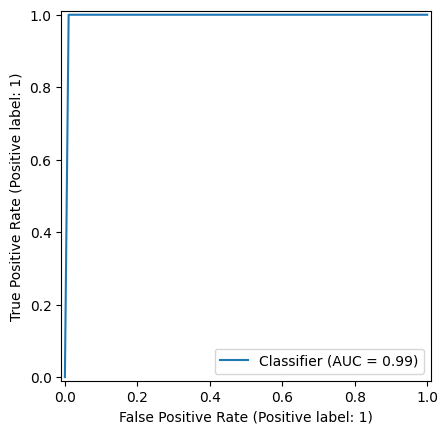

In [30]:
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
RocCurveDisplay.from_predictions(y_test, y_pred)

# Redução de dimensionalidade

In [39]:
pipeline_transformadora = imblearn.pipeline.Pipeline([
    ('scaler', RandomUnderSampler(random_state = 42)),
    ('preprocessing', CustomPreprocessor(aplicar_processamento = False)),
    ('embedding', Embedding(n_grams = 3, tipo_embedding = 'WORD2VEC'))
])

In [40]:
pipeline_transformadora.fit(X_train, y_train)

Pipeline(steps=[('scaler', RandomUnderSampler(random_state=42)),
                ('preprocessing', CustomPreprocessor()),
                ('embedding', Embedding(n_grams=3, tipo_embedding='WORD2VEC'))])

## PCA

In [68]:
from sklearn.decomposition import PCA

In [69]:
pca = PCA(n_components=2)
pca.fit(pipeline_transformadora.transform(X_test))

PCA(n_components=2)

<Axes: xlabel='PCA1', ylabel='PCA2'>

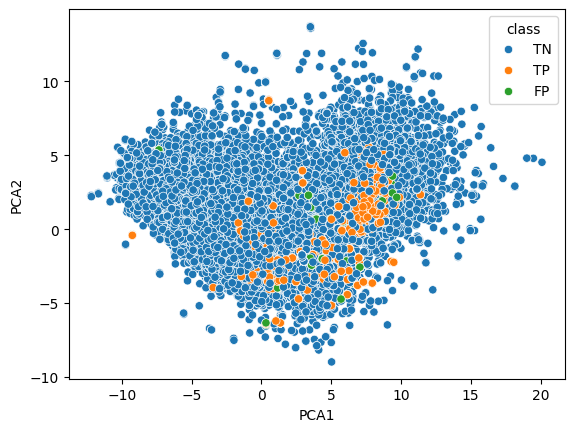

In [85]:
X_test_2d = X_test.copy()
X_test_2d = pd.DataFrame( pca.transform( pipeline_transformadora.transform(X_test_2d) ), columns = ["PCA1", "PCA2"] )

def classify(row):
    if row['y_pred'] == 1 and row['y_test'] == 1:
        return 'TP'
    elif row['y_pred'] == 1 and row['y_test'] == 0:
        return 'FP'
    elif row['y_pred'] == 0 and row['y_test'] == 0:
        return 'TN'
    elif row['y_pred'] == 0 and row['y_test'] == 1:
        return 'FN'
    return 'Unknown'

X_test_2d["y_pred"] = y_pred
X_test_2d["y_test"] = y_test.reset_index(drop = True)
X_test_2d['class'] = X_test_2d.apply(classify, axis=1)

sns.scatterplot(data = X_test_2d, x = "PCA1", y = "PCA2", hue = "class")

## UMAP

In [90]:
import umap.umap_ as umap


In [92]:
umap_reducer = umap.UMAP(n_components=2)
umap_reducer.fit(pipeline_transformadora.transform(X_test))

C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[1.56894143e-15 1.07854914e-06 2.35460408e-06 1.20362383e-05]
not reaching the requested tolerance 5.677342414855957e-06.
Use iteration 1843 instead with accuracy 
2.5459785368215465e-06.

  _, diffusion_map = lobpcg(
C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.89244762e-15 1.19886077e-06 3.14396102e-06 5.84104673e-06]
not reaching the requested tolerance 5.677342414855957e-06.
  _, diffusion_map = lobpcg(
C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\si

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<Axes: xlabel='PCA1', ylabel='PCA2'>

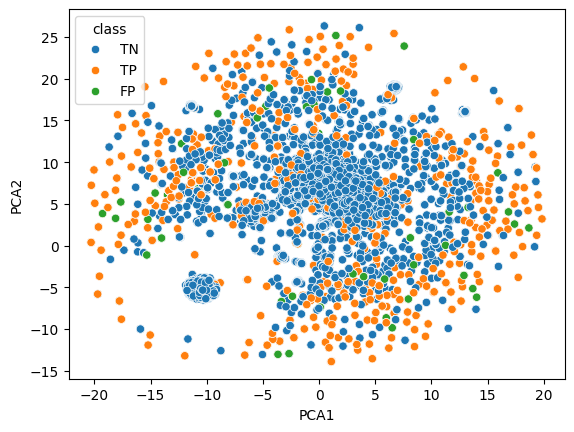

In [93]:
X_test_2d = X_test.copy()
X_test_2d = pd.DataFrame( umap_reducer.transform( pipeline_transformadora.transform(X_test_2d) ), columns = ["PCA1", "PCA2"] )

def classify(row):
    if row['y_pred'] == 1 and row['y_test'] == 1:
        return 'TP'
    elif row['y_pred'] == 1 and row['y_test'] == 0:
        return 'FP'
    elif row['y_pred'] == 0 and row['y_test'] == 0:
        return 'TN'
    elif row['y_pred'] == 0 and row['y_test'] == 1:
        return 'FN'
    return 'Unknown'

X_test_2d["y_pred"] = y_pred
X_test_2d["y_test"] = y_test.reset_index(drop = True)
X_test_2d['class'] = X_test_2d.apply(classify, axis=1)

sns.scatterplot(data = X_test_2d, x = "PCA1", y = "PCA2", hue = "class")